Combine summarized coverage (07c) & market volume (08b/c), with a break-out focus on Indian markets / PCC's

Version notes:

e: one-way

d: use POS to determine what we should target for MMT

c: Expand / modify "average" coverage score, following discussion with Joel Fisher and Greg H
- they are most interested in knowing where "drop-off" in coverage occurs
    - implied, not stated: with respect to market volume
- "high" / "good-enough" coverage depends on how good mechanisms to fill gaps are
    - so, for now, assume close to 100%, at least only missing 1/30 days (96.66%)

## import, setup

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

In [2]:
# pretty print a row
def pp_row(df):
    cols = df.columns
    out = df.take(1)
    for i, x in enumerate(out[0]):
        print(cols[i], x)

Need to re-compute coverage summary, so run in cluster mode

In [3]:
APP_NAME = "KF-ShopGrid-Jupyter"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
        ("spark.driver.memory","20g"),
        ("spark.master","yarn"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 5),
        ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

spark.sparkContext.applicationId

'application_1658797823938_3218'

## args

In [4]:
# define dates
max_days_til_dept = 120 # args.days_til_dept
max_stay_duration = 30 #args.length_of_stay

missing_search_days_str = [] #args.missing_dates or []
num_missing_days = len(missing_search_days_str)

# load & prep data

TODO: combine data from different "versions" of shop_vol data

In [5]:
# coverage input data
input_dir = "/user/kendra.frederick/shop_vol/v5/decoded/with_pcc/"
cov_df = spark.read.option("mergeSchema", True).parquet(input_dir)

# NEW: derive shopping dates from data, instead of them being supplied as arguments
search_start_str = cov_df.select(F.min("searchDt").alias("x")).collect()[0]["x"]
search_end_str = cov_df.select(F.max("searchDt").alias("x")).collect()[0]["x"]

search_start = datetime.datetime.strptime(str(search_start_str), "%Y%m%d").date()
search_end = datetime.datetime.strptime(str(search_end_str), "%Y%m%d").date()

num_search_days = (search_end - search_start).days + 1
num_search_days_adj = num_search_days - num_missing_days

# OUTBOUND DEPARTURE DATES
min_dept_dt = search_start # this includes same-day searches
max_dept_dt = search_end + datetime.timedelta(days=max_days_til_dept)
max_return_dt = max_dept_dt + datetime.timedelta(days=max_stay_duration)

# min_dept_dt, max_dept_dt, max_return_dt
search_start, search_end

(datetime.date(2022, 8, 22), datetime.date(2022, 8, 31))

In [46]:
num_search_days

10

In [8]:
# cov_df.show(5)

+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
| market|outDeptDt|inDeptDt|round_trip|shop_counts|min_fare|pos|currency| pcc|origin|destination|searchDt|
+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
|SJC-JFK| 20220901|       0|         0|         20|   358.6| US|     USD| OMW|   SJC|        JFK|20220825|
|KBV-BKK| 20220914|       0|         0|         21|  1089.0| TW|     TWD| 4D6|   KBV|        BKK|20220825|
|PUS-BKK| 20221001|20221005|         1|          5|594000.0| KR|     KRW|64T3|   PUS|        BKK|20220825|
|HKG-SFO| 20221029|       0|         0|         48|  769.57| US|     USD| J86|   HKG|        SFO|20220825|
|LHR-BKK| 20221002|20221025|         1|          5|  868.76| GB|     GBP| V8T|   LHR|        BKK|20220825|
+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
only showing top 5 rows



In [6]:
in_pos_cov_df = cov_df.filter(F.col("pos") == "IN")

In [9]:
# in_pos_cov_df.count() / cov_df.count()

0.07275320024834489

Filter on indian markets

In [7]:
airport_df = spark.read.csv("/data/reference/AIRPORT.CSV", header=True)

in_cov_join_df = (in_pos_cov_df
                  .join(
                    airport_df.select('airport_code', 'country_code'),
                    on=[in_pos_cov_df['origin'] == airport_df['airport_code']],
                  ).withColumnRenamed("country_code", "origin_country")
                  .drop("airport_code")
                 )
in_cov_join_df = (in_cov_join_df
                  .join(
                    airport_df.select('airport_code', 'country_code'),
                    on=[in_pos_cov_df['destination'] == airport_df['airport_code']],
                  ).withColumnRenamed("country_code", "destination_country")
                  .drop("airport_code")
                 )

in_mrkt_cov_df = in_cov_join_df.filter(
    (F.col('origin_country') == "IN") & (F.col("destination_country") == "IN")
)

Modify processing function for one-way flights

In [10]:
def process_oneway_coverage_data(df):
    # updated column names
    df = df.withColumn("market", 
        F.concat_ws("-", F.col("origin"), F.col("destination")))

    # convert Dept dates (which are strings) to datetime
    df.registerTempTable("data")
    df = spark.sql("""
        SELECT *,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
        FROM data
    """)
    
    # TODO: could clean up variable names here
    
    # filter on dates & round-trip
    # TODO: don't need both this filter and the one on days til dept
    df_filt = (df
                .filter(F.col("outDeptDt_dt").between(min_dept_dt, max_dept_dt))
            )
    df_ow = df_filt.filter(F.col("round_trip") == 0)
    
#     df_filt = df_filt.withColumn('stay_duration',
#                 F.datediff(
#                     F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
#                 )
    # Note this effectively filters out null stay durations, which are one-way trips
#     df_filt = df_filt.filter(F.col('stay_duration').between(0, max_stay_duration))

    df_ow = df_ow.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                    )
    df_ow = df_ow.filter(F.col('days_til_dept').between(0, max_days_til_dept))
    
    # BY DAYS TIL DEPT
    dtd_df = (df_ow
                .groupBy(["market", "days_til_dept"])
              # add agg to pull shop counts over
                .agg(
                    F.countDistinct("searchDt_dt").alias("obs_num_days"),
                    F.sum("shop_counts").alias("shop_counts")
                )
                .withColumn("pct_shop_coverage", F.col("obs_num_days") / num_search_days)
                .withColumn("pct_shop_coverage_adj", F.col("obs_num_days") / num_search_days_adj)           
                .repartition("market")
              )
#     dtd_df.cache()
    return dtd_df

In [11]:
in_pos_ow_agg = process_oneway_coverage_data(in_pos_cov_df)

In [13]:
in_mrkt_ow_agg = process_oneway_coverage_data(in_mrkt_cov_df)

In [15]:
in_pos_ow_agg.show(5)

+-------+-------------+------------+-----------+-----------------+---------------------+
| market|days_til_dept|obs_num_days|shop_counts|pct_shop_coverage|pct_shop_coverage_adj|
+-------+-------------+------------+-----------+-----------------+---------------------+
|SAW-STN|          118|           9|         64|              0.9|                  0.9|
|SZB-PEN|            5|          10|        934|              1.0|                  1.0|
|LHR-DXB|           66|          10|        277|              1.0|                  1.0|
|BLR-DEL|           53|          10|       9511|              1.0|                  1.0|
|XNB-BOM|            2|          10|       4490|              1.0|                  1.0|
+-------+-------------+------------+-----------+-----------------+---------------------+
only showing top 5 rows



In [16]:
in_mrkt_ow_agg.show(5)

+-------+-------------+------------+-----------+-----------------+---------------------+
| market|days_til_dept|obs_num_days|shop_counts|pct_shop_coverage|pct_shop_coverage_adj|
+-------+-------------+------------+-----------+-----------------+---------------------+
|DEL-GOI|           87|          10|       3889|              1.0|                  1.0|
|BLR-DEL|           63|          10|       3933|              1.0|                  1.0|
|BLR-DEL|           14|          10|      13956|              1.0|                  1.0|
|DEL-SXR|            3|          10|      21470|              1.0|                  1.0|
|BOM-AMD|           11|          10|       9478|              1.0|                  1.0|
+-------+-------------+------------+-----------+-----------------+---------------------+
only showing top 5 rows



In [18]:
in_mrkt_ow_agg.count()

2541

In [ ]:
# # filter on LOS, to restrict our analysis
# los_start, los_end = 1, 7
# in_pos_agg_los_0107 = in_pos_ow_agg.filter(F.col("stay_duration").between(los_start, los_end))
# in_mrkt_agg_los_0107 = in_mrkt_ow_agg.filter(F.col("stay_duration").between(los_start, los_end))

In [17]:
# # do we still need this?
# in_pos_covg_summ_0107 = (in_pos_agg_los_0107
#                   .groupBy("market", "days_til_dept")
#                   .agg(
#                       F.mean("pct_shop_coverage").alias("avg_coverage"),
#                       # keep pulling shop counts over
#                       F.sum("shop_counts").alias("shop_counts")
#                   )
#                  )

In [25]:
pdf_in_pos_ow_summ = in_pos_ow_agg.toPandas()

In [27]:
pdf_in_mrkt_ow_summ = in_mrkt_ow_agg.toPandas()

# plot

For all below: Shopping data 08/22-08/31 - One-way trips

shopping volume vs. avg coverage

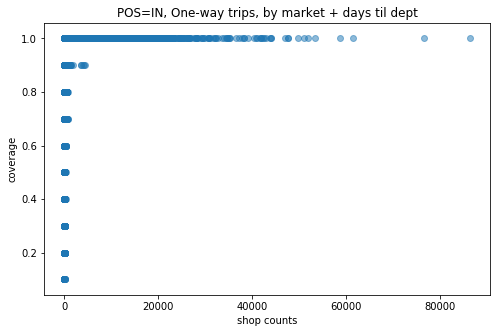

In [29]:
plt.figure(figsize=(8,5))
plt.scatter(pdf_in_pos_ow_summ['shop_counts'], pdf_in_pos_ow_summ['pct_shop_coverage'], alpha=0.5);
plt.xlabel("shop counts");
plt.ylabel("coverage");
plt.title("POS=IN, One-way trips, by market + days til dept");

Get market list ranked / sorted by volume that is represented on coverage data

In [32]:
in_pos_ow_vols = in_pos_ow_agg.groupby(["market"]).agg(F.sum('shop_counts').alias('sum_shop_counts'))
w = Window.orderBy(F.desc("sum_shop_counts"))
in_pos_ow_vols = in_pos_ow_vols.withColumn("rank", F.rank().over(w))
ow_in_pos_market_list = [x['market'] for x in in_pos_ow_vols.orderBy("rank").select('market').collect()]

In [36]:
len(ow_in_pos_market_list)

1000

In [37]:
in_mrkt_ow_vols = in_mrkt_ow_agg.groupby(["market"]).agg(F.sum('shop_counts').alias('sum_shop_counts'))
w = Window.orderBy(F.desc("sum_shop_counts"))
in_mrkt_ow_vols = in_mrkt_ow_vols.withColumn("rank", F.rank().over(w))
ow_in_mrkt_market_list = [x['market'] for x in in_mrkt_ow_vols.orderBy("rank").select('market').collect()]

In [38]:
len(ow_in_mrkt_market_list)

21

Now, pivot data, and plot

In [40]:
pdf_in_pos_ow_summ.head()

,market,days_til_dept,obs_num_days,shop_counts,pct_shop_coverage,pct_shop_coverage_adj
0,BLR-DEL,29,10,10287,1.0,1.0
1,DEL-SIN,2,10,4042,1.0,1.0
2,LHR-DEL,12,10,1114,1.0,1.0
3,ICN-CDG,60,10,81,1.0,1.0
4,XNB-DEL,52,10,1394,1.0,1.0


In [41]:
in_pos_ow_pvt = pdf_in_pos_ow_summ.pivot(index='days_til_dept', columns='market', values='pct_shop_coverage')

In [42]:
top_n = 50
markets_to_plot = ow_in_pos_market_list[:top_n]
in_pos_ow_pvt_plot = in_pos_ow_pvt[markets_to_plot].transpose()

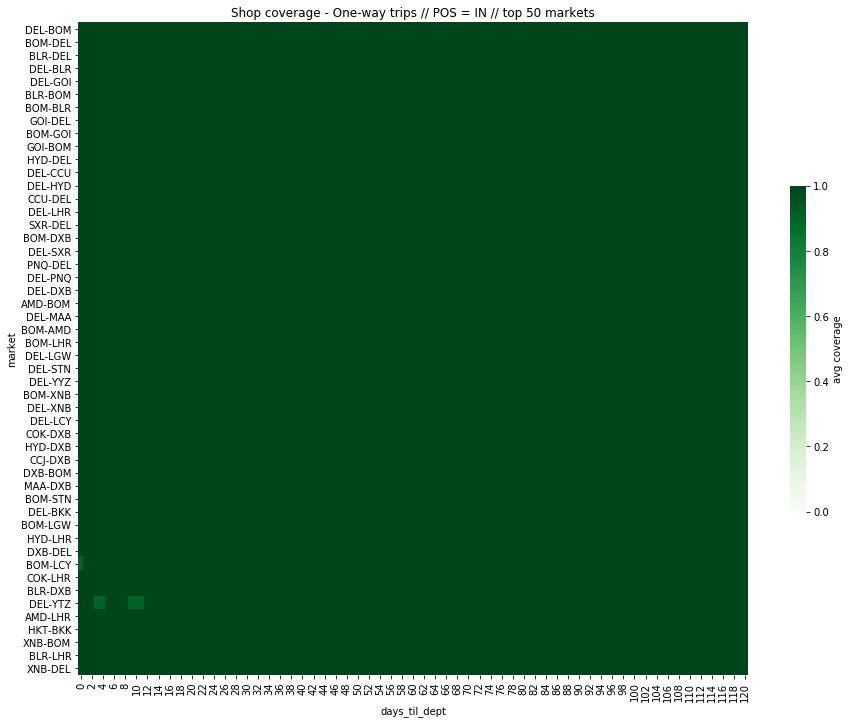

In [43]:
plt.figure(figsize=(15,12))
sns.heatmap(in_pos_ow_pvt_plot, 
            cmap='Greens', #square=True,
            vmin=0,
            cbar_kws={'label': 'avg coverage',
                      'shrink': 0.5}
           );
plt.title("Shop coverage - One-way trips // POS = IN // top 50 markets");

Note XNB = Dubai Bus Station

In [45]:
pdf_in_pos_ow_summ[pdf_in_pos_ow_summ['market'] == 'XNB-DEL'].sort_values(by='days_til_dept')

,market,days_til_dept,obs_num_days,shop_counts,pct_shop_coverage,pct_shop_coverage_adj
12074,XNB-DEL,0,10,3600,1.0,1.0
10758,XNB-DEL,1,10,6172,1.0,1.0
13968,XNB-DEL,2,10,4063,1.0,1.0
4700,XNB-DEL,3,10,3742,1.0,1.0
5356,XNB-DEL,4,10,3451,1.0,1.0
13457,XNB-DEL,5,10,3107,1.0,1.0
2078,XNB-DEL,6,10,2927,1.0,1.0
8583,XNB-DEL,7,10,2989,1.0,1.0
7604,XNB-DEL,8,10,2652,1.0,1.0
13781,XNB-DEL,9,10,2533,1.0,1.0


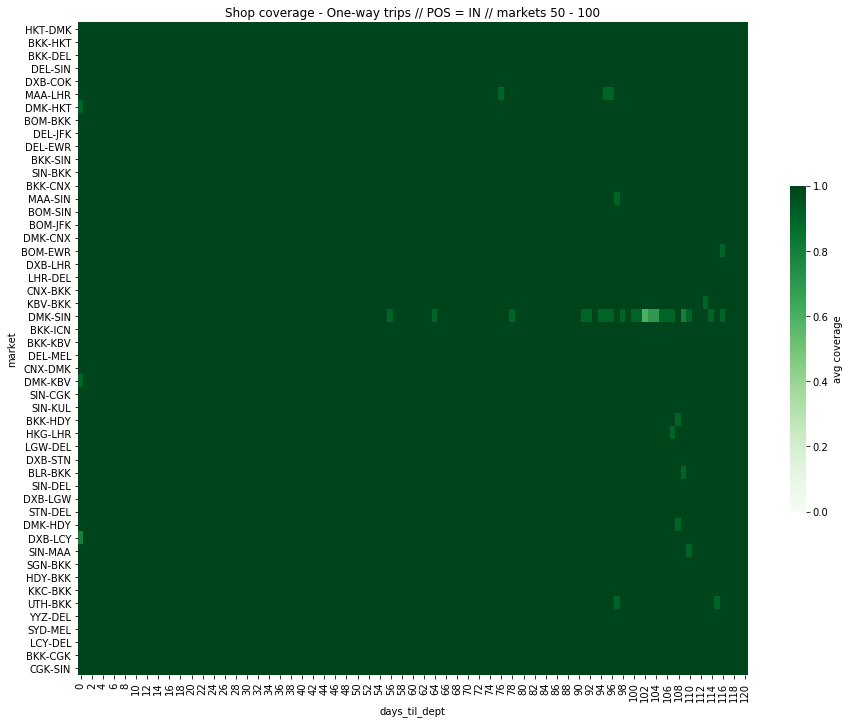

In [57]:
start, stop = 50, 100
markets_to_plot = ow_in_pos_market_list[start:stop]
in_pos_ow_pvt_plot = in_pos_ow_pvt[markets_to_plot].transpose()

plt.figure(figsize=(15,12))
sns.heatmap(in_pos_ow_pvt_plot, 
            cmap='Greens', #square=True,
            vmin=0,
            cbar_kws={'label': 'avg coverage',
                      'shrink': 0.5}
           );
plt.title(f"Shop coverage - One-way trips // POS = IN // markets {start} - {stop}");

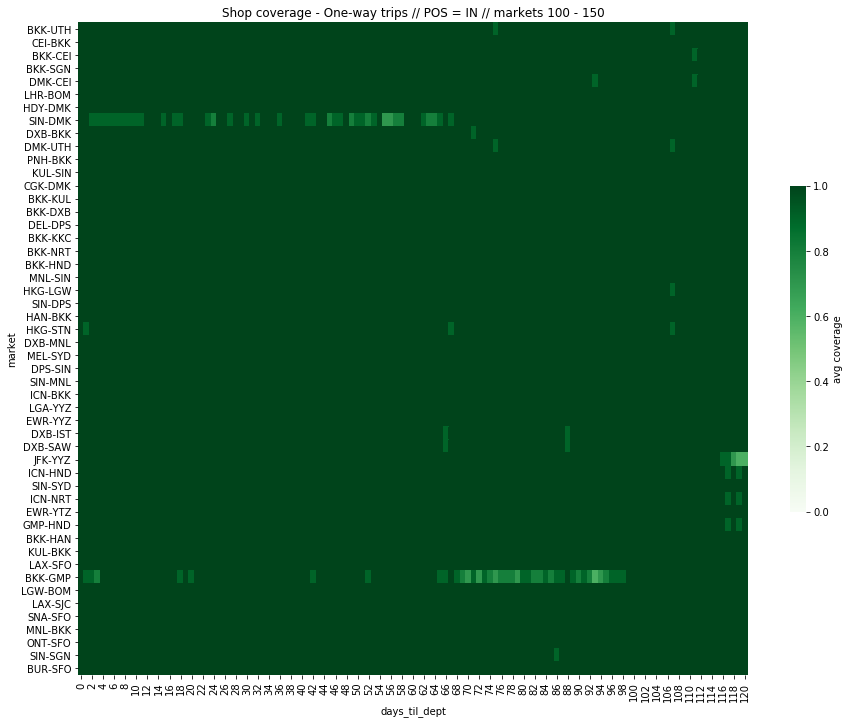

In [58]:
start, stop = 100, 150
markets_to_plot = ow_in_pos_market_list[start:stop]
in_pos_ow_pvt_plot = in_pos_ow_pvt[markets_to_plot].transpose()

plt.figure(figsize=(15,12))
sns.heatmap(in_pos_ow_pvt_plot, 
            cmap='Greens', #square=True,
            vmin=0,
            cbar_kws={'label': 'avg coverage',
                      'shrink': 0.5}
           );
plt.title(f"Shop coverage - One-way trips // POS = IN // markets {start} - {stop}");

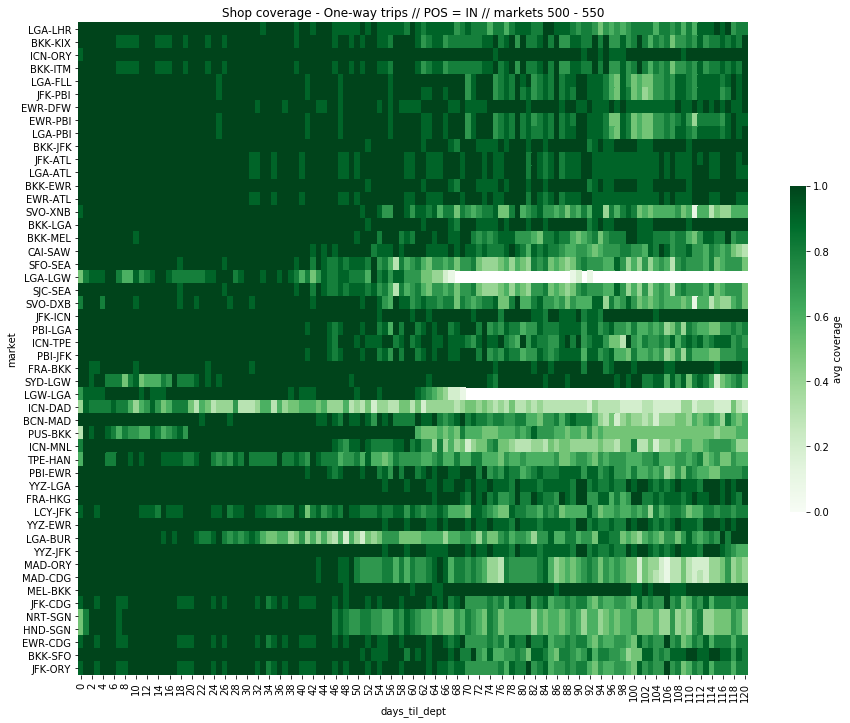

In [60]:
start, stop = 500, 550
markets_to_plot = ow_in_pos_market_list[start:stop]
in_pos_ow_pvt_plot = in_pos_ow_pvt[markets_to_plot].transpose()

plt.figure(figsize=(15,12))
sns.heatmap(in_pos_ow_pvt_plot, 
            cmap='Greens', #square=True,
            vmin=0,
            cbar_kws={'label': 'avg coverage',
                      'shrink': 0.5}
           );
plt.title(f"Shop coverage - One-way trips // POS = IN // markets {start} - {stop}");

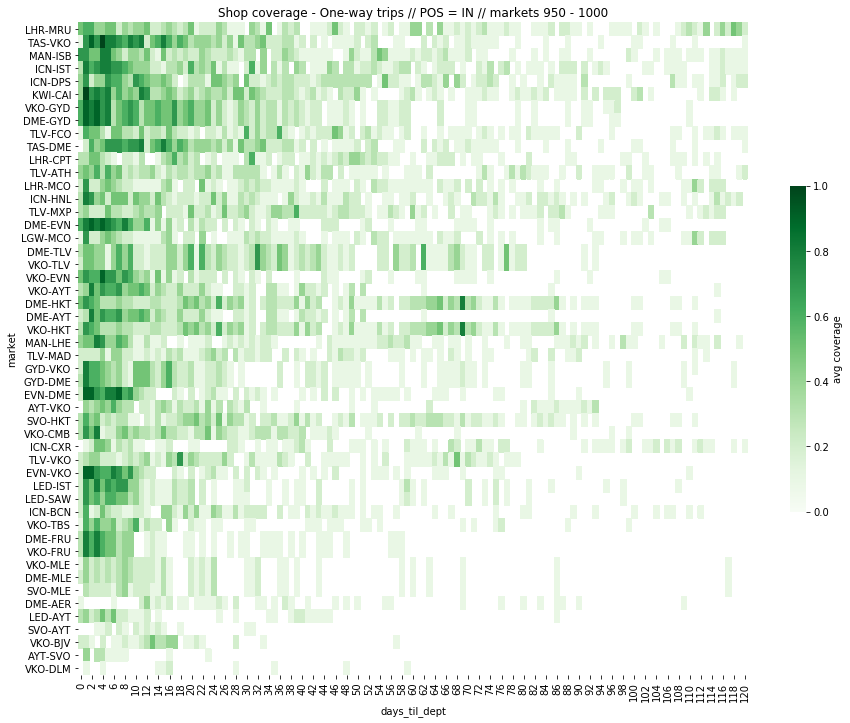

In [59]:
start, stop = 950, 1000
markets_to_plot = ow_in_pos_market_list[start:stop]
in_pos_ow_pvt_plot = in_pos_ow_pvt[markets_to_plot].transpose()

plt.figure(figsize=(15,12))
sns.heatmap(in_pos_ow_pvt_plot, 
            cmap='Greens', #square=True,
            vmin=0,
            cbar_kws={'label': 'avg coverage',
                      'shrink': 0.5}
           );
plt.title(f"Shop coverage - One-way trips // POS = IN // markets {start} - {stop}");

Indian Markets

In [53]:
# pivot & plot

in_mrkt_ow_pvt = pdf_in_mrkt_ow_summ.pivot(index='days_til_dept', columns='market', values='pct_shop_coverage')
in_mrkt_ow_pvt_plot = in_mrkt_ow_pvt[ow_in_mrkt_market_list].transpose()

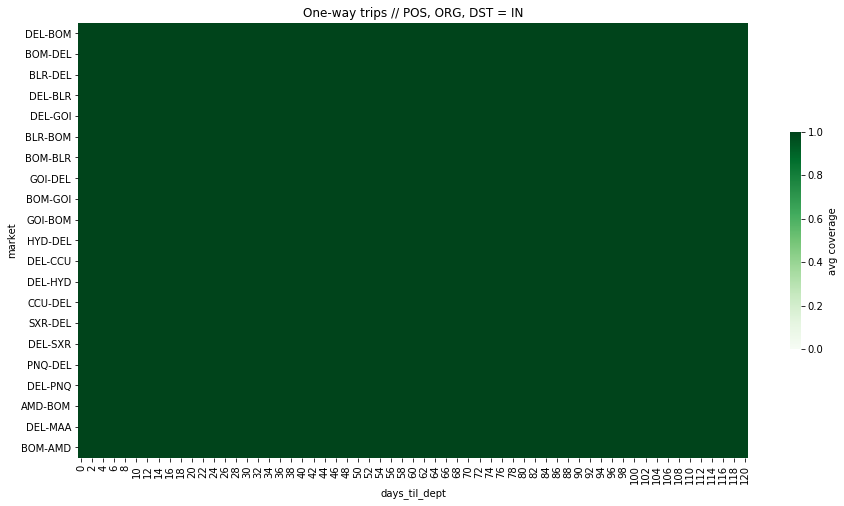

In [55]:
plt.figure(figsize=(15,8))
sns.heatmap(in_mrkt_ow_pvt_plot, 
            cmap='Greens', #square=True,
            vmin=0,
            cbar_kws={'label': 'avg coverage',
                      'shrink': 0.5}
           );
plt.title("One-way trips // POS, ORG, DST = IN");

# other POS / currencies

In [61]:
mrkt_pos_cnts = cov_df.groupby('market', 'pos', 'currency').count()

In [62]:
mrkt_pos_cnts.show()

+-------+---+--------+------+
| market|pos|currency| count|
+-------+---+--------+------+
|MEL-AKL| US|     USD| 37818|
|LHR-EWR| US|     USD|276204|
|ZRH-BKK| US|     USD| 56776|
|LHR-AYT| GB|     GBP|149828|
|LGA-FLL| US|     USD|162027|
|MNL-HND| US|     USD| 42030|
|TPE-SIN| TW|     CNY| 23013|
|IST-DUS| GB|     GBP| 24474|
|HKG-SIN| US|     USD| 39543|
|GYD-DXB| DE|     EUR|  9412|
|MAD-CDG| HK|     HKD| 14257|
|LGA-SEA| CA|     CAD|  5895|
|ICN-SGN| US|     USD| 21488|
|JFK-CUN| US|     USD|182575|
|AMS-EWR| US|     USD| 55653|
|YYZ-DEL| CA|     CAD|224250|
|ICN-IST| KR|     KRW|127064|
|HYD-LHR| US|     USD| 13267|
|LHR-JFK| US|     USD|285442|
|NRT-ICN| HK|     HKD| 69672|
+-------+---+--------+------+
only showing top 20 rows



In [64]:
mrkt_pos_cnts.filter(F.col('market') == 'DEL-BOM').orderBy(F.desc("count")).show()

+-------+---+--------+------+
| market|pos|currency| count|
+-------+---+--------+------+
|DEL-BOM| IN|     INR|133278|
|DEL-BOM| HK|     HKD| 43312|
|DEL-BOM| US|     USD| 36585|
|DEL-BOM| GB|     GBP| 29779|
|DEL-BOM| IN|     CNY| 18284|
|DEL-BOM| CA|     CAD| 18167|
|DEL-BOM| FR|     EUR|  6288|
|DEL-BOM| BD|     BDT|  4856|
|DEL-BOM| AU|     AUD|  3817|
|DEL-BOM| RU|     RUB|  3579|
|DEL-BOM| DE|     EUR|  2899|
|DEL-BOM| TW|     CNY|  2435|
|DEL-BOM| KW|     KWD|  1603|
|DEL-BOM| NL|     INR|  1584|
|DEL-BOM| TH|     THB|  1581|
|DEL-BOM| MY|     MYR|  1116|
|DEL-BOM| SG|     SGD|   863|
|DEL-BOM| IT|     EUR|   834|
|DEL-BOM| ES|     EUR|   774|
|DEL-BOM| NZ|     NZD|   403|
+-------+---+--------+------+
only showing top 20 rows



In [66]:
mrkt_pos_cnts.filter(F.col('market') == 'DEL-HYD').orderBy(F.desc("count")).show()

+-------+---+--------+-----+
| market|pos|currency|count|
+-------+---+--------+-----+
|DEL-HYD| IN|     INR|62482|
|DEL-HYD| HK|     HKD|24317|
|DEL-HYD| CA|     CAD|10222|
|DEL-HYD| US|     USD| 7515|
|DEL-HYD| FR|     EUR| 4426|
|DEL-HYD| GB|     GBP| 3684|
|DEL-HYD| BD|     BDT| 3142|
|DEL-HYD| AU|     AUD| 2057|
|DEL-HYD| TW|     CNY| 2027|
|DEL-HYD| NL|     INR| 1174|
|DEL-HYD| DE|     EUR|  930|
|DEL-HYD| KW|     KWD|  691|
|DEL-HYD| IN|     CNY|  652|
|DEL-HYD| SG|     SGD|  498|
|DEL-HYD| TH|     THB|  371|
|DEL-HYD| NZ|     NZD|  242|
|DEL-HYD| IT|     EUR|  164|
|DEL-HYD| RU|     RUB|  137|
|DEL-HYD| ES|     EUR|  134|
|DEL-HYD| TR|     TRY|  114|
+-------+---+--------+-----+
only showing top 20 rows



In [65]:
mrkt_pos_cnts.filter(F.col('market') == 'LGA-SEA').orderBy(F.desc("count")).show()

+-------+---+--------+-----+
| market|pos|currency|count|
+-------+---+--------+-----+
|LGA-SEA| US|     USD|77931|
|LGA-SEA| HK|     HKD| 8150|
|LGA-SEA| GB|     GBP| 7417|
|LGA-SEA| CA|     CAD| 5895|
|LGA-SEA| IN|     CNY| 2180|
|LGA-SEA| HK|     CNY| 2170|
|LGA-SEA| AE|     AED| 2088|
|LGA-SEA| IN|     INR| 1252|
|LGA-SEA| AU|     AUD|  849|
|LGA-SEA| DE|     EUR|  664|
|LGA-SEA| IT|     EUR|  358|
|LGA-SEA| GB|     USD|  341|
|LGA-SEA| TW|     CNY|  269|
|LGA-SEA| IN|     USD|  264|
|LGA-SEA| ES|     EUR|  175|
|LGA-SEA| KW|     KWD|  164|
|LGA-SEA| SE|     SEK|  159|
|LGA-SEA| KR|     KRW|  128|
|LGA-SEA| IL|     USD|  119|
|LGA-SEA| TR|     TRY|   75|
+-------+---+--------+-----+
only showing top 20 rows



In [67]:
cov_df.show(5)

+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
| market|outDeptDt|inDeptDt|round_trip|shop_counts|min_fare|pos|currency| pcc|origin|destination|searchDt|
+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
|SJC-JFK| 20220901|       0|         0|         20|   358.6| US|     USD| OMW|   SJC|        JFK|20220825|
|KBV-BKK| 20220914|       0|         0|         21|  1089.0| TW|     TWD| 4D6|   KBV|        BKK|20220825|
|PUS-BKK| 20221001|20221005|         1|          5|594000.0| KR|     KRW|64T3|   PUS|        BKK|20220825|
|HKG-SFO| 20221029|       0|         0|         48|  769.57| US|     USD| J86|   HKG|        SFO|20220825|
|LHR-BKK| 20221002|20221025|         1|          5|  868.76| GB|     GBP| V8T|   LHR|        BKK|20220825|
+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
only showing top 5 rows



In [68]:
pos_cnts = cov_df.groupby('pos').agg(F.sum("shop_counts").alias("shop_counts"))
pos_cnts.orderBy(F.desc("shop_counts")).show(20)

+---+-----------+
|pos|shop_counts|
+---+-----------+
| US|  345047425|
| GB|  200955682|
| HK|  183262417|
| RU|  116748298|
| CA|   84099454|
| IN|   75602991|
| TW|   65059442|
| DE|   64365867|
| AU|   47205806|
| TH|   43032816|
| JP|   34465561|
| KR|   29783540|
| PH|   19585172|
| ES|   15603505|
| IT|   11312102|
| FR|   10978134|
| IL|    9158053|
| MY|    9123726|
| AE|    8708276|
| PT|    8428679|
+---+-----------+
only showing top 20 rows



In [69]:
country_df = spark.read.csv("/data/reference/COUNTRY.CSV", header=True)

In [70]:
country_df.show(5)

+-----------+--------------------+-------------+---------+-------------+-----------------------+---------+-----------+
|2_char_code|                name|currency_code|IATA_code|postal_digits|associated_city_airport|continent|3_char_code|
+-----------+--------------------+-------------+---------+-------------+-----------------------+---------+-----------+
|         AD|             Andorra|          EUR|       20|            0|                      Y|   EUROPE|        AND|
|         AE|United Arab Emirates|          AED|      784|            0|                      Y|   MIDEST|        ARE|
|         AF|         Afghanistan|          AFN|        4|            0|                      Y|     ASIA|        AFG|
|         AG| Antigua And Barbuda|          XCD|       28|            0|                      Y|   CARRIB|        ATG|
|         AI|            Anguilla|          XCD|      660|            0|                      Y|   CARRIB|        AIA|
+-----------+--------------------+-------------+

In [71]:
pos_cnts= (pos_cnts.join(country_df.select("2_char_code", "name"),
                        on=pos_cnts["pos"] == country_df['2_char_code']
                       )
           .withColumnRenamed("name", "country_name")
           .drop("2_char_code")
          )

In [73]:
pos_cnts.select("pos", "country_name", "shop_counts").orderBy(F.desc("shop_counts")).show(20)

+---+--------------------+-----------+
|pos|        country_name|shop_counts|
+---+--------------------+-----------+
| US|       United States|  345047425|
| GB|      United Kingdom|  200955682|
| HK|           Hong Kong|  183262417|
| RU|  Russian Federation|  116748298|
| CA|              Canada|   84099454|
| IN|               India|   75602991|
| TW|              Taiwan|   65059442|
| DE|             Germany|   64365867|
| AU|           Australia|   47205806|
| TH|            Thailand|   43032816|
| JP|               Japan|   34465561|
| KR|  Korea, Republic Of|   29783540|
| PH|         Philippines|   19585172|
| ES|               Spain|   15603505|
| IT|               Italy|   11312102|
| FR|              France|   10978134|
| IL|              Israel|    9158053|
| MY|            Malaysia|    9123726|
| AE|United Arab Emirates|    8708276|
| PT|            Portugal|    8428679|
+---+--------------------+-----------+
only showing top 20 rows



Ignore Russia

In [74]:
spark.stop()